<a href="https://colab.research.google.com/github/Vasanta2002/sprint_6/blob/main/JDS_SHR_221_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---


# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model 

In [49]:
%%capture 
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# pd.options.display.max_rows = 100

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API. 

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download dataset

In [51]:
# mounting your google drive on colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

In [53]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contians the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [54]:
# Download your Kaggle Dataset, if you haven't already done so 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle" # providing the config path to kaggle.json 
!kaggle competitions download -c bloomtech-water-pump-challenge # downloading dataset by running the Kaggle API command

bloomtech-water-pump-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [55]:
# Unzip your Kaggle dataset, if you haven't already done so.
#!unzip \*.zip  && rm *.zip

In [56]:
# List all files in your Kaggle folder on your google drive.
!ls

bloomtech-water-pump-challenge.zip  sample_submission.csv  train_features.csv
kaggle.json			    test_features.csv	   train_labels.csv


# I. Wrangle Data

### Import data



In [57]:
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test_features = pd.read_csv('test_features.csv')

In [58]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
1,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
3,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
4,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [59]:
train_labels.head()

,id,status_group
0,454,functional
1,510,functional
2,14146,non functional
3,47410,non functional
4,1288,non functional


In [60]:
test_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,37098,0.0,2012-10-09,Rural Water Supply And Sanitat,0,DWE,31.985658,-3.596360,Kasela,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
1,14530,0.0,2012-11-03,Halmashauri Ya Manispa Tabora,0,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,0,...,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
2,62607,10.0,2013-02-25,Siter Fransis,1675,DWE,35.488289,-4.242048,Kwa Leosi,0,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
3,46053,0.0,2011-08-13,Kkkt,0,KKKT,33.140828,-9.059386,Jangi,0,...,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
4,47083,50.0,2013-02-08,Wateraid,1109,SEMA,34.217077,-4.430529,Mkima,0,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


In [61]:
train = pd.merge(pd.read_csv('train_features.csv'), pd.read_csv('train_labels.csv'))
X_test = pd.read_csv('test_features.csv')

### EDA

In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47520 entries, 0 to 47519
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     47520 non-null  int64  
 1   amount_tsh             47520 non-null  float64
 2   date_recorded          47520 non-null  object 
 3   funder                 44644 non-null  object 
 4   gps_height             47520 non-null  int64  
 5   installer              44631 non-null  object 
 6   longitude              47520 non-null  float64
 7   latitude               47520 non-null  float64
 8   wpt_name               47520 non-null  object 
 9   num_private            47520 non-null  int64  
 10  basin                  47520 non-null  object 
 11  subvillage             47224 non-null  object 
 12  region                 47520 non-null  object 
 13  region_code            47520 non-null  int64  
 14  district_code          47520 non-null  int64  
 15  lg

In [63]:
ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/49 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
train = pd.merge(pd.read_csv('train_features.csv',na_values=[0, -2.000000e-08]), 
                 pd.read_csv('train_labels.csv'))
X_test = pd.read_csv('test_features.csv', na_values=[0, -2.000000e-08])


def wrangle(df):

  # Set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  # Drop High Cardinality Columns
  threshold = 100
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > threshold]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of zeros
  df.drop(columns='num_private', inplace=True)

  return df

train = wrangle(train)
X_test = wrangle(X_test)


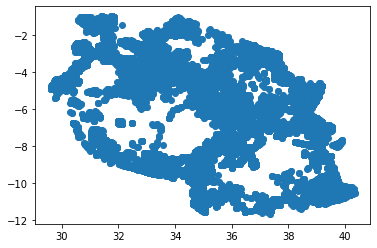

In [65]:
# null island! 
# bunch of data coordinates at 0,0

plt.scatter(train['longitude'], train['latitude'])
plt.show()

In [66]:
train[train['latitude'] ==0]

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,


In [67]:
train[train['longitude'] ==0]

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,


In [68]:
train.head(100).T.duplicated()

amount_tsh               False
gps_height               False
longitude                False
latitude                 False
basin                    False
region                   False
region_code              False
district_code            False
population               False
public_meeting           False
scheme_management        False
permit                   False
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_group            False
quantity                 False
source                   False
source_type              False
source_class             False
waterpoint_type          False
waterpoint_type_group    False
status_group             False
dtype: bool

# II. Split Data

## Split TV from FM

In [69]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

## Training-Validation Split

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

# III. Establish Baseline

- Is this a *regression* or a *classification* problem?

In [71]:
print('baseline accuracy:',y_train.value_counts(normalize=True).max())

baseline accuracy: 0.5425489938182296


# IV. Build Model(s)

**First Model:** Logistic Regression

In [72]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter=200)
)

model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=200))])

**Second Model:** Decision Tree Classifier

In [81]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42, max_depth=16)
)

model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -

**Interlude: How does a tree model work?**

[Text(0.5, 0.875, 'quantity <= 1.5\ngini = 0.553\nsamples = 38015\nvalue = [20625, 2779, 14611]'),
 Text(0.25, 0.625, 'region <= 1.5\ngini = 0.063\nsamples = 4056\nvalue = [104, 27, 3925]'),
 Text(0.125, 0.375, 'longitude <= 32.736\ngini = 0.257\nsamples = 232\nvalue = [34, 1, 197]'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'construction_year <= 2011.5\ngini = 0.049\nsamples = 3824\nvalue = [70, 26, 3728]'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'waterpoint_type_group <= 3.5\ngini = 0.529\nsamples = 33959\nvalue = [20521, 2752, 10686]'),
 Text(0.625, 0.375, 'payment <= 2.5\ngini = 0.5\nsamples = 30704\nvalue = [19932, 2564, 8208]'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'extraction_type_class <= 3.5\ngini = 0.384\nsamples = 3255\nvalue = [589, 188, 2478]'),
 Text(0.8125, 0.125, '\n  (...)  \n'),
 Text(0.9375, 0.

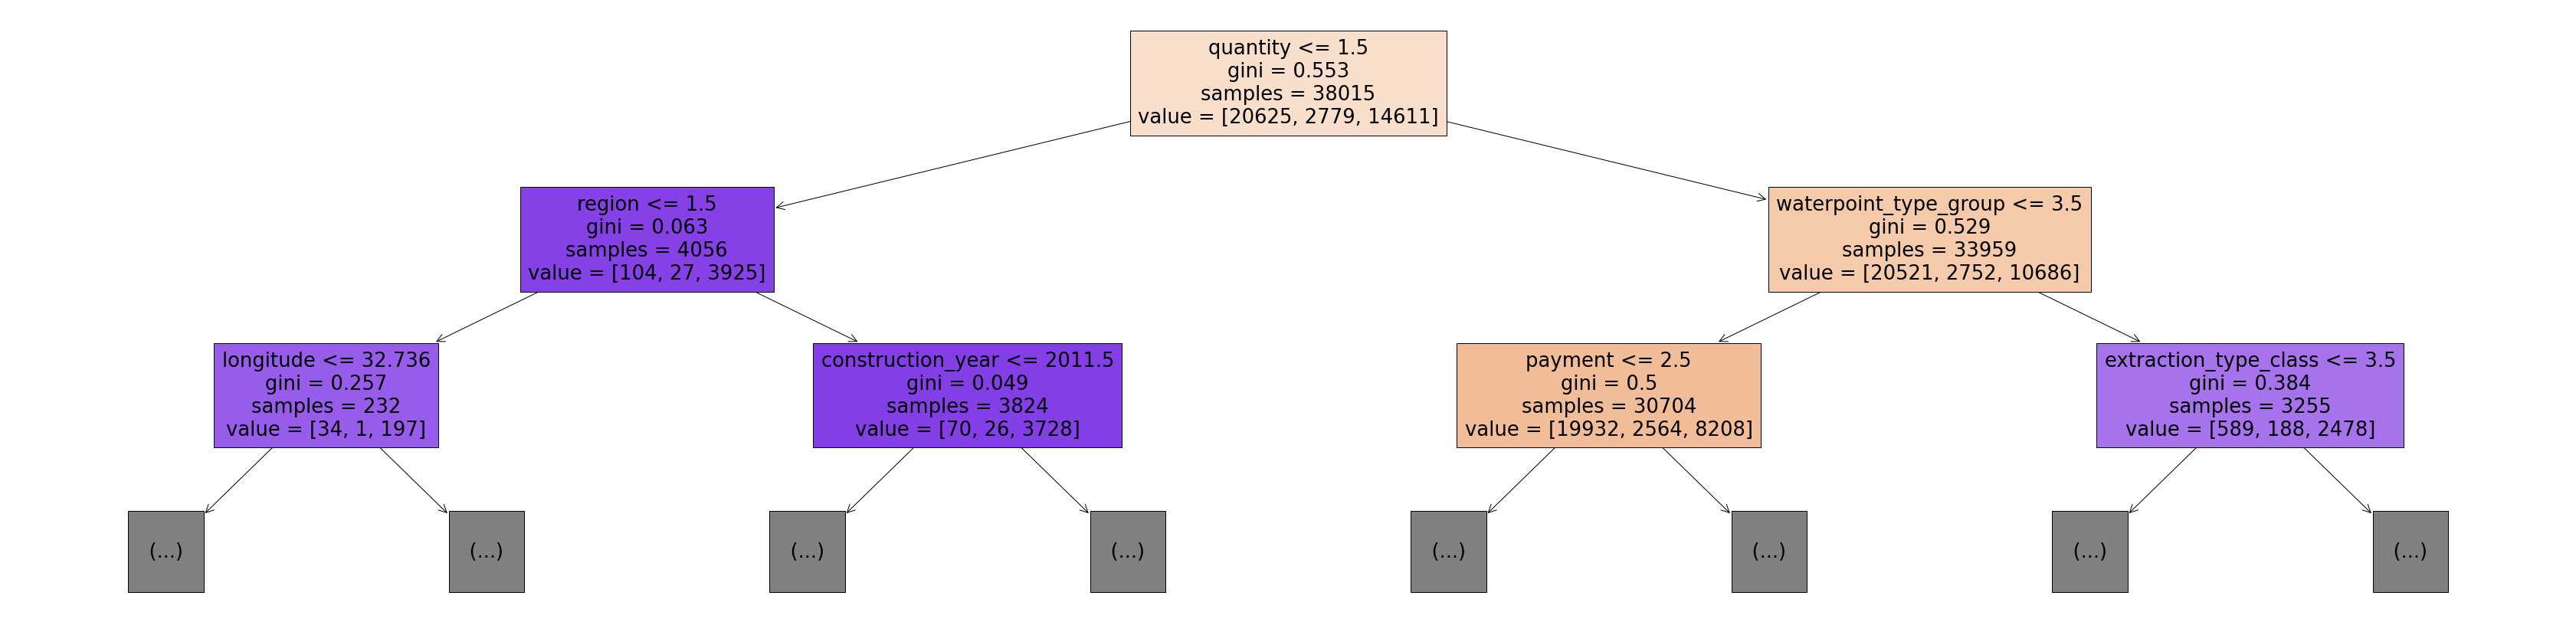

In [74]:
plt.figure(figsize=(60,15))
plot_tree(model_dt.named_steps['decisiontreeclassifier'],
          max_depth=2,
          feature_names=X_train.columns,
          filled=True)

# V. Check Metrics

In [48]:
print('model_lr accuracy score for training',accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val',accuracy_score(y_val, model_lr.predict(X_val)) )

model_lr accuracy score for training 0.7387347099829015
model_lr accuracy score for val 0.7322180134680135


In [76]:

print('model_dt accuracy score for training',accuracy_score(y_train, model_dt.predict(X_train)) )
print('model_dt accuracy score for val',accuracy_score(y_val, model_dt.predict(X_val)) )

model_dt accuracy score for training 0.995475470209128
model_dt accuracy score for val 0.7411616161616161


In [82]:
print('model_dt accuracy score for training',accuracy_score(y_train, model_dt.predict(X_train)) )
print('model_dt accuracy score for val',accuracy_score(y_val, model_dt.predict(X_val)) )

model_dt accuracy score for training 0.8781007497040642
model_dt accuracy score for val 0.7639941077441077


# VI. Tune Model

In [77]:
model_dt.named_steps['decisiontreeclassifier'].get_depth()

38

In [78]:
depths = range(5, 20, 2)
list(depths)

[5, 7, 9, 11, 13, 15, 17, 19]

In [79]:
# very similar steps to how we tuned alpha for ridge regression

train_acc = []
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
                    
  )
  
  
  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

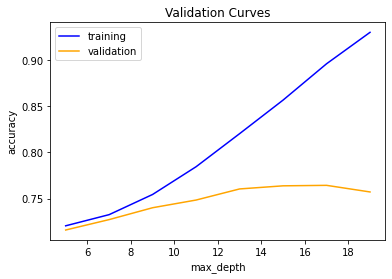

In [80]:

plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES! 
plt.legend()
plt.show()

# VII. Communicate Results


### Gini importance

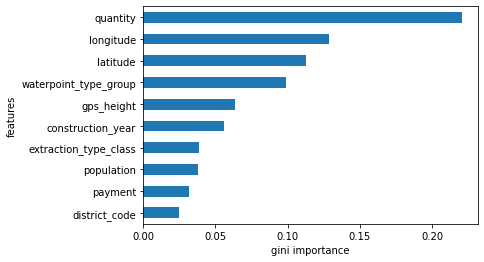

In [83]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini_importances = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini_importances, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

# VIII. Kaggle Submission

In [84]:
predictions = pd.DataFrame(data=model_lr.predict(X_test), index=X_test.index)

In [85]:
predictions.columns = ['status_group']

In [86]:
predictions

,status_group
id,
37098,non functional
14530,functional
62607,functional
46053,non functional
47083,functional
...,...
26092,functional
919,functional
47444,non functional


In [87]:
# generate CSV
predictions.to_csv('new_submission.csv')

In [88]:
# download
from google.colab import files
files.download("new_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>